<a href="https://colab.research.google.com/github/tsitsvero/rotor-gp/blob/main/pack/train_eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install dependencies

In [18]:
!pip install git+https://github.com/lab-cosmo/librascal gpytorch pytorch-lightning wandb git+https://github.com/chem-gp/fande xtb nbstripout
! nbstripout --install --global

  Cloning https://github.com/lab-cosmo/librascal to /tmp/pip-req-build-ufpjb1v8
  Running command git clone --filter=blob:none --quiet https://github.com/lab-cosmo/librascal /tmp/pip-req-build-ufpjb1v8
  Resolved https://github.com/lab-cosmo/librascal to commit 6c55e99720f9a181f1efc5c7cd4976c87809d79b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/chem-gp/fande to /tmp/pip-req-build-heot65o9
  Running command git clone --filter=blob:none --quiet https://github.com/chem-gp/fande /tmp/pip-req-build-heot65o9
  Resolved https://github.com/chem-gp/fande to commit 353b1733424bfdd15a117ac41dd5f909ed5ce40c
  Preparing metadata (setup.py) ... done


In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
!wget https://raw.githubusercontent.com/tsitsvero/rotor-gp/main/pack/cook_model.py

--2023-12-31 14:32:33--  https://raw.githubusercontent.com/tsitsvero/rotor-gp/main/pack/cook_model.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9070 (8.9K) [text/plain]
Saving to: ‘cook_model.py.1’

cook_model.py.1     100%[===================>]   8.86K  --.-KB/s    in 0s      

2023-12-31 14:32:33 (75.3 MB/s) - ‘cook_model.py.1’ saved [9070/9070]



## Cooking up the model

In [21]:
# Prepare the training data:

from ase import io
import os

# DATA_DIR = os.path.expanduser("~/repos/data/")
# # DATA_DIR = "/data1/simulations/datasets/rotors/high_temp_ML_training_data/"
# RESULTS_DIR = os.path.expanduser("~/repos/data/results")

DATA_DIR = os.path.expanduser("/content/drive/MyDrive/data/")
# FANDE_DIR = os.path.expanduser("~/")
RESULTS_DIR = os.path.expanduser("/content/drive/MyDrive/data/results/")
os.makedirs(RESULTS_DIR, exist_ok=True)

PREPARE_DATA = False
if PREPARE_DATA:
        traj_295 = io.read(DATA_DIR+"/results_triasine_ML_2000/struct_295_295K/md_trajectory.traj", index=":")
        # traj_355 = io.read(DATA_DIR+"/results_triasine_ML_2000/struct_355_355K/md_trajectory.traj", index=":")
        traj_295_2000K = io.read(DATA_DIR+"/results_triasine_ML_2000/struct_295_2000K/md_trajectory.traj", index=":")
        # traj_355_2000K = io.read(DATA_DIR+"/results_triasine_ML_2000/struct_355_2000K/md_trajectory.traj", index=":")
        # traj_295_2000K_forced = io.read(DATA_DIR+"/results_triasine_ML_2000/struct_295_2000K_0075force/md_trajectory.traj", index=":")
        # traj_355_2000K_forced = io.read(DATA_DIR+"/results_triasine_ML_2000/struct_355_2000K_0075force/md_trajectory.traj", index=":")

        # trajectory_energy = traj_295[0:5000] + traj_355[0:5000] + traj_295_2000K[0:5000] + traj_355_2000K[0:5000] + traj_295_2000K_forced[0:5000] + traj_355_2000K_forced[0:5000]

        train_energy = traj_295[0:5000:10] +  traj_295_2000K[0:5000:10]
        train_forces = traj_295_2000K[0:5000:5]
        validation_energy = traj_295[1000:1010]
        validation_forces = traj_295[1000:1010]

        io.write(DATA_DIR+"/train_energy.traj", train_energy)
        io.write(DATA_DIR+"/train_forces.traj", train_forces)
        io.write(DATA_DIR+"/validation_energy.traj", validation_energy)
        io.write(DATA_DIR+"/validation_forces.traj", validation_forces)


In [22]:
%%time
# ENERGY_MODEL = 'variational_inducing_points' #'variational_inducing_points', 'exact'
# ENERGY_NUM_INDUCING_POINTS = 10
# ENERGY_LR = 0.1
# ENERGY_NUM_STEPS = 5

# FORCES_MODEL = 'variational_inducing_points' #'variational_inducing_points', 'exact'
# FORCES_NUM_INDUCING_POINTS = 10
# NUM_FORCE_SAMPLES = 10
# FORCES_LR = 0.1
# FORCES_NUM_STEPS = 5

# PREDICTOR_NAME = 'test.pth'
# SUBSAMPLE = 200 # subsample data to reduce time durings tests


ENERGY_MODEL = 'exact' #'variational_inducing_points', 'exact'
ENERGY_NUM_INDUCING_POINTS = 500
ENERGY_LR = 0.01
ENERGY_NUM_STEPS = 2000

FORCES_MODEL = 'exact' #'variational_inducing_points', 'exact'
FORCES_NUM_INDUCING_POINTS = 500
NUM_FORCE_SAMPLES = 1000
FORCES_LR = 0.01
FORCES_NUM_STEPS = 2000

PREDICTOR_NAME = 'exact.pth'
SUBSAMPLE = 2 # subsample data to reduce time durings tests

! python cook_model.py \
--data_dir $DATA_DIR \
--results_dir $RESULTS_DIR \
--energy_model $ENERGY_MODEL \
--energy_num_inducing_points $ENERGY_NUM_INDUCING_POINTS \
--energy_lr $ENERGY_LR \
--energy_num_steps $ENERGY_NUM_STEPS \
--forces_model $FORCES_MODEL \
--forces_num_inducing_points $FORCES_NUM_INDUCING_POINTS \
--num_force_samples $NUM_FORCE_SAMPLES \
--forces_lr $FORCES_LR \
--forces_num_steps $FORCES_NUM_STEPS \
--predictor_name $PREDICTOR_NAME \
--subsample $SUBSAMPLE


DATA_DIR /content/drive/MyDrive/data/
RESULTS_DIR /content/drive/MyDrive/data/results/
ENERGY_MODEL exact
ENERGY_NUM_INDUCING_POINTS 500
ENERGY_LR 0.01
ENERGY_NUM_STEPS 2000
FORCES_MODEL exact
FORCES_NUM_INDUCING_POINTS 500
NUM_FORCE_SAMPLES 1000
FORCES_LR 0.01
FORCES_NUM_STEPS 2000
PREDICTOR_NAME exact.pth
500 500
fande.models module imported...
Icecream logger is not available
Total number of found groups: 14
Checking if all atoms are covered:  True
Preparing dataloaders...
Total length of traj is 500
Total number of batches 500
Calculating invariants on trajectory with librascal...
100% 500/500 [00:21<00:00, 23.33it/s]
invariants for energy fitting calculated
100% 500/500 [13:25<00:00,  1.61s/it]
invariants for forces fitting calculated
torch.Size([500, 1200])
torch.Size([500])
Dataloader for group 0 created
Number of samples in dataloader: 1000
Dataloader for group 1 created
Number of samples in dataloader: 1000
Dataloader for group 2 created
Number of samples in dataloader: 1000
D

In [23]:
%%time
ENERGY_MODEL = 'variational_inducing_points' #'variational_inducing_points', 'exact'
ENERGY_NUM_INDUCING_POINTS = 500
ENERGY_LR = 0.01
ENERGY_NUM_STEPS = 2000

FORCES_MODEL = 'variational_inducing_points' #'variational_inducing_points', 'exact'
FORCES_NUM_INDUCING_POINTS = 500
NUM_FORCE_SAMPLES = 1000
FORCES_LR = 0.01
FORCES_NUM_STEPS = 2000

PREDICTOR_NAME = 'inducing.pth'
SUBSAMPLE = 2 # subsample data to reduce time durings tests

! python cook_model.py \
--data_dir $DATA_DIR \
--results_dir $RESULTS_DIR \
--energy_model $ENERGY_MODEL \
--energy_num_inducing_points $ENERGY_NUM_INDUCING_POINTS \
--energy_lr $ENERGY_LR \
--energy_num_steps $ENERGY_NUM_STEPS \
--forces_model $FORCES_MODEL \
--forces_num_inducing_points $FORCES_NUM_INDUCING_POINTS \
--num_force_samples $NUM_FORCE_SAMPLES \
--forces_lr $FORCES_LR \
--forces_num_steps $FORCES_NUM_STEPS \
--predictor_name $PREDICTOR_NAME \
--subsample $SUBSAMPLE

DATA_DIR /content/drive/MyDrive/data/
RESULTS_DIR /content/drive/MyDrive/data/results/
ENERGY_MODEL variational_inducing_points
ENERGY_NUM_INDUCING_POINTS 500
ENERGY_LR 0.01
ENERGY_NUM_STEPS 2000
FORCES_MODEL variational_inducing_points
FORCES_NUM_INDUCING_POINTS 500
NUM_FORCE_SAMPLES 1000
FORCES_LR 0.01
FORCES_NUM_STEPS 2000
PREDICTOR_NAME inducing.pth
500 500
fande.models module imported...
Icecream logger is not available
Total number of found groups: 14
Checking if all atoms are covered:  True
Preparing dataloaders...
Total length of traj is 500
Total number of batches 500
Calculating invariants on trajectory with librascal...
100% 500/500 [00:23<00:00, 21.63it/s]
invariants for energy fitting calculated
100% 500/500 [13:33<00:00,  1.63s/it]
invariants for forces fitting calculated
torch.Size([500, 1200])
torch.Size([500])
Dataloader for group 0 created
Number of samples in dataloader: 1000
Dataloader for group 1 created
Number of samples in dataloader: 1000
Dataloader for group 2 

## Testing models

In [24]:
from ase import io
test_traj = io.read(DATA_DIR + "/results_triasine_ML_2000/struct_295_295K/md_trajectory.traj", index="1000:1010")

In [25]:
import sys
import torch
FANDE_DIR = os.path.expanduser("~/repos/")
sys.path.append(FANDE_DIR + "fande/")

from fande.predict import FandePredictor
from fande.ase import FandeCalc
# load the predictor:
# predictor_loaded = torch.load(RESULTS_DIR + "/fande_predictor.pth")
predictor_loaded = torch.load(RESULTS_DIR + "/exact.pth")
fande_calc_loaded = FandeCalc(predictor_loaded)
device = torch.device('cpu')
fande_calc_loaded.predictor.move_models_to_device(device)

In [26]:
forces_true = []
forces_predicted = []

energy_true = []
energy_predicted = []

for atoms in test_traj:
    forces_true.append(atoms.get_forces())
    energy_true.append(atoms.get_potential_energy())
    atoms.set_calculator(fande_calc_loaded)
    forces_predicted.append(atoms.get_forces())
    energy_predicted.append(atoms.get_potential_energy())

INFO:fande:Setting context for descriptors calculation to production


Time for invariants (call from forces):  2014.8131847381592
Predicting forces...


INFO:fande:Setting context for descriptors calculation to production


Energy model summary: 
Time invariants:  0.17690658569335938
Time prediction:  116.06431007385254
Time moving on device:  0.23889541625976562
Time total:  124.27592277526855


INFO:fande:Setting context for descriptors calculation to production


Time for invariants (call from forces):  1944.1051483154297
Predicting forces...
Energy model summary: 
Time invariants:  0.17642974853515625
Time prediction:  3.8597583770751953
Time moving on device:  0.2410411834716797
Time total:  6.224632263183594


INFO:fande:Setting context for descriptors calculation to production


Time for invariants (call from forces):  1678.816556930542
Predicting forces...
Energy model summary: 
Time invariants:  0.1990795135498047
Time prediction:  3.654956817626953
Time moving on device:  0.293731689453125
Time total:  5.450010299682617


INFO:fande:Setting context for descriptors calculation to production


Time for invariants (call from forces):  1624.1319179534912
Predicting forces...
Energy model summary: 
Time invariants:  0.1995563507080078
Time prediction:  3.9391517639160156
Time moving on device:  0.293731689453125
Time total:  5.670785903930664
Time for invariants (call from forces):  1635.6675624847412
Predicting forces...


INFO:fande:Setting context for descriptors calculation to production


Energy model summary: 
Time invariants:  0.22077560424804688
Time prediction:  92.67663955688477
Time moving on device:  0.28634071350097656
Time total:  107.30934143066406


INFO:fande:Setting context for descriptors calculation to production


Time for invariants (call from forces):  1616.1324977874756
Predicting forces...
Energy model summary: 
Time invariants:  0.20623207092285156
Time prediction:  60.472965240478516
Time moving on device:  0.339508056640625
Time total:  68.74895095825195


INFO:fande:Setting context for descriptors calculation to production


Time for invariants (call from forces):  1730.2041053771973
Predicting forces...
Energy model summary: 
Time invariants:  0.1957416534423828
Time prediction:  3.838777542114258
Time moving on device:  0.27680397033691406
Time total:  5.858182907104492


INFO:fande:Setting context for descriptors calculation to production


Time for invariants (call from forces):  1735.7070446014404
Predicting forces...
Energy model summary: 
Time invariants:  0.20551681518554688
Time prediction:  19.178152084350586
Time moving on device:  0.274658203125
Time total:  29.615402221679688


INFO:fande:Setting context for descriptors calculation to production


Time for invariants (call from forces):  1764.9178504943848
Predicting forces...
Energy model summary: 
Time invariants:  0.18310546875
Time prediction:  3.7734508514404297
Time moving on device:  0.2715587615966797
Time total:  11.973381042480469
Time for invariants (call from forces):  1725.0957489013672
Predicting forces...
Energy model summary: 
Time invariants:  0.18215179443359375
Time prediction:  3.8604736328125
Time moving on device:  8.580207824707031
Time total:  20.4317569732666


Atomic group [0, 1, 2, 3, 4, 5, 264, 265, 266, 267, 268, 269]
F_x
MAE 0.12102109274226887
RMSE 0.18545447945199459
F_y
MAE 0.31588018977815757
RMSE 0.39646243765513955
F_z
MAE 0.2278611687841797
RMSE 0.2661310398166057
E
MAE 0.4932021406875083
RMSE 0.6320239581193261


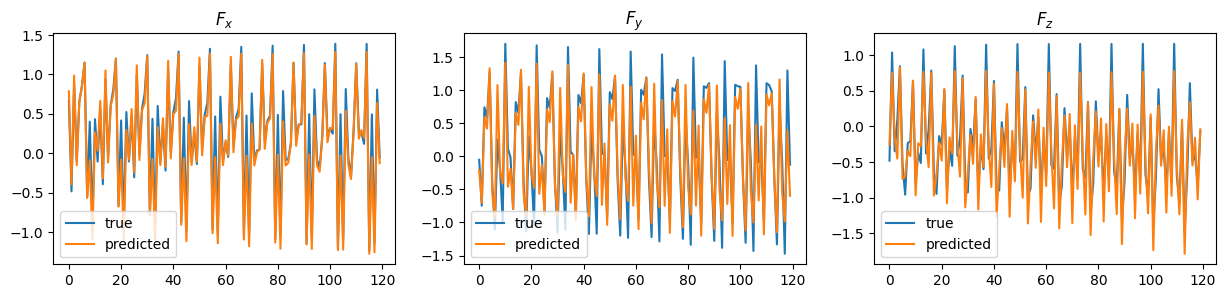

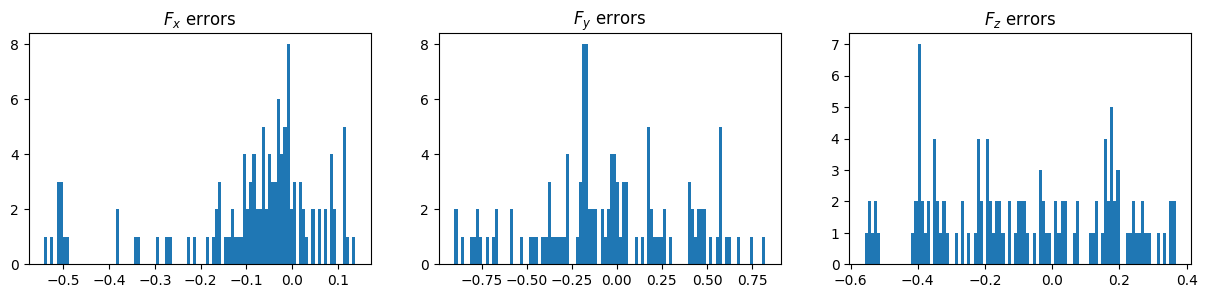

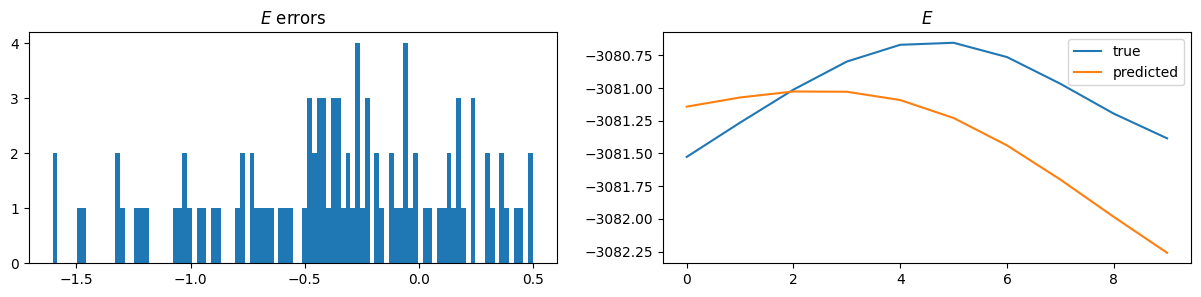

Atomic group [146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 5

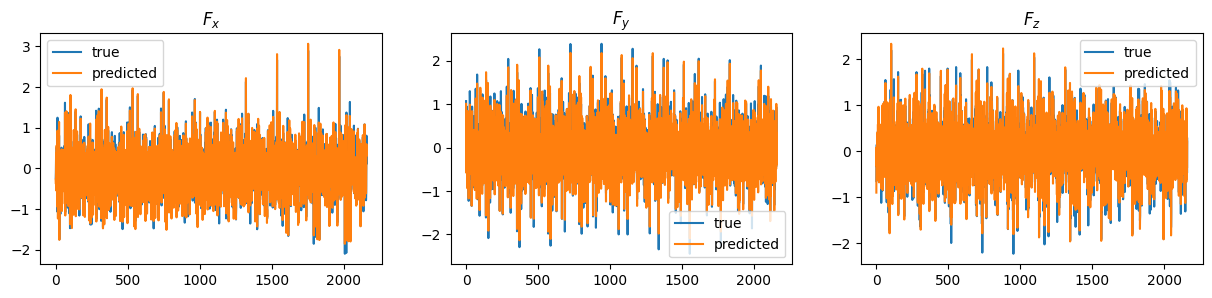

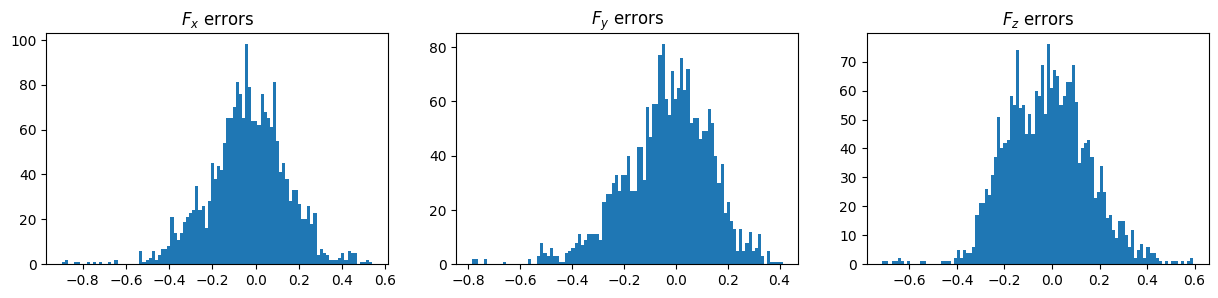

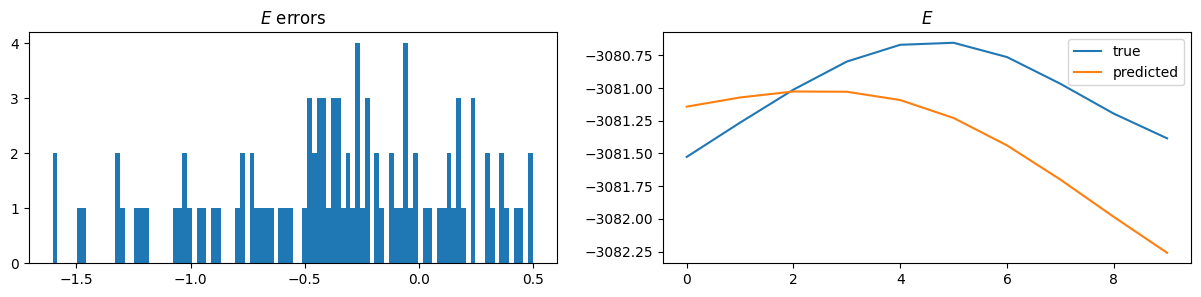

Atomic group [56, 57, 58, 59, 60, 61, 66, 67, 68, 69, 70, 71, 72, 73, 76, 77, 78, 79, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 98, 99, 100, 101, 320, 321, 322, 323, 324, 325, 330, 331, 332, 333, 334, 335, 336, 337, 340, 341, 342, 343, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 362, 363, 364, 365]
F_x
MAE 0.2897194440566949
RMSE 0.38184444465190387
F_y
MAE 0.2835090805830485
RMSE 0.36311167175668924
F_z
MAE 0.2987293402924669
RMSE 0.4193661355935145
E
MAE 0.4932021406875083
RMSE 0.6320239581193261


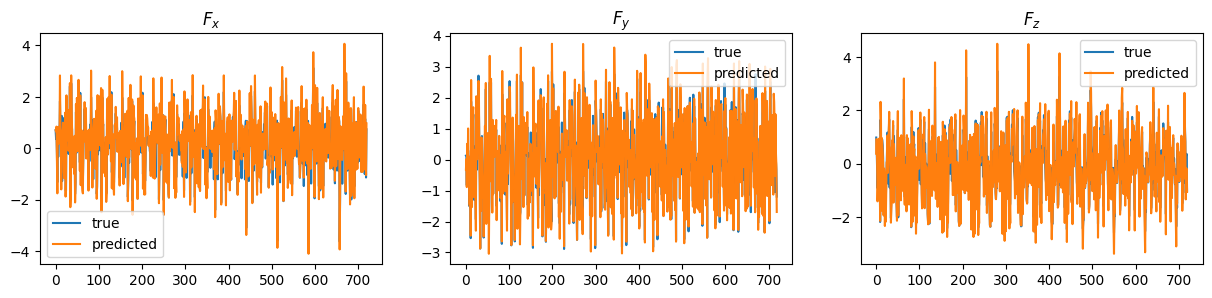

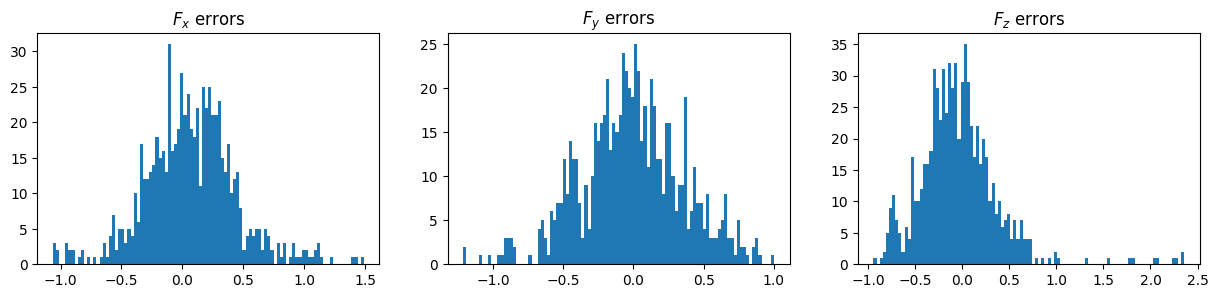

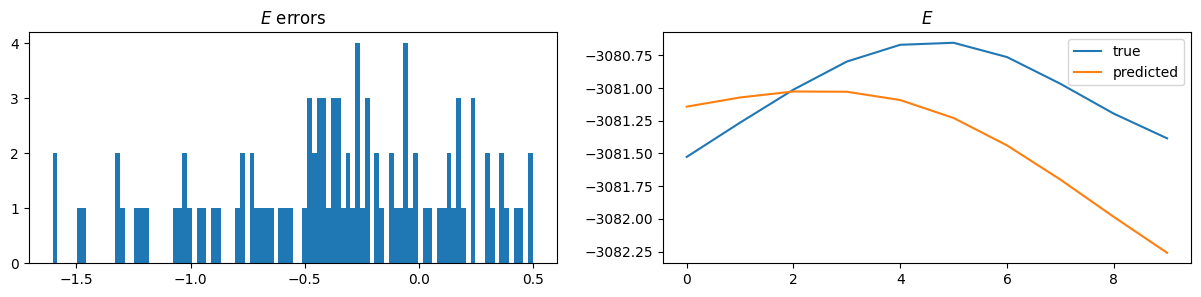

Atomic group [108, 109, 110, 111, 112, 113, 372, 373, 374, 375, 376, 377]
F_x
MAE 0.16814923307552082
RMSE 0.20513250204585617
F_y
MAE 0.18301206486035154
RMSE 0.23415796955112245
F_z
MAE 0.1819063228391927
RMSE 0.22930385864951275
E
MAE 0.4932021406875083
RMSE 0.6320239581193261


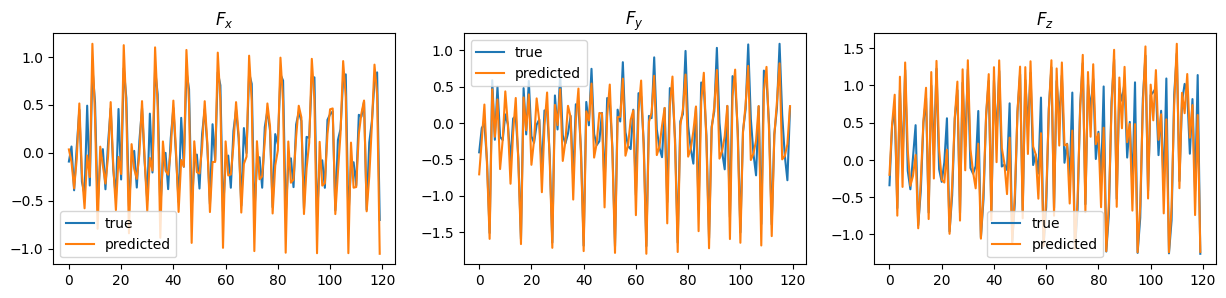

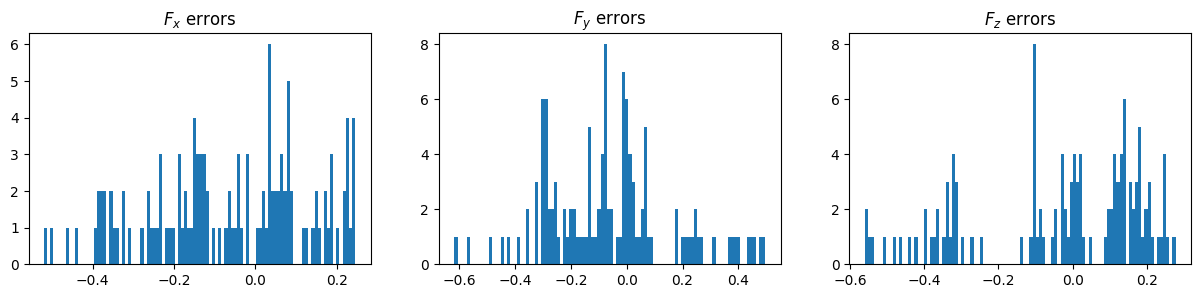

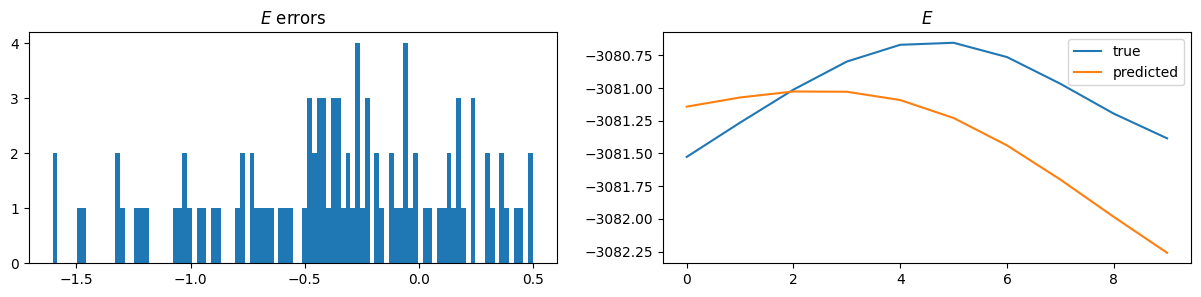

Atomic group [6, 7, 8, 9, 10, 11, 270, 271, 272, 273, 274, 275]
F_x
MAE 0.2714177509645589
RMSE 0.3244613303526041
F_y
MAE 0.12867062895699055
RMSE 0.1490171986379661
F_z
MAE 0.12558502516959633
RMSE 0.16226961907044357
E
MAE 0.4932021406875083
RMSE 0.6320239581193261


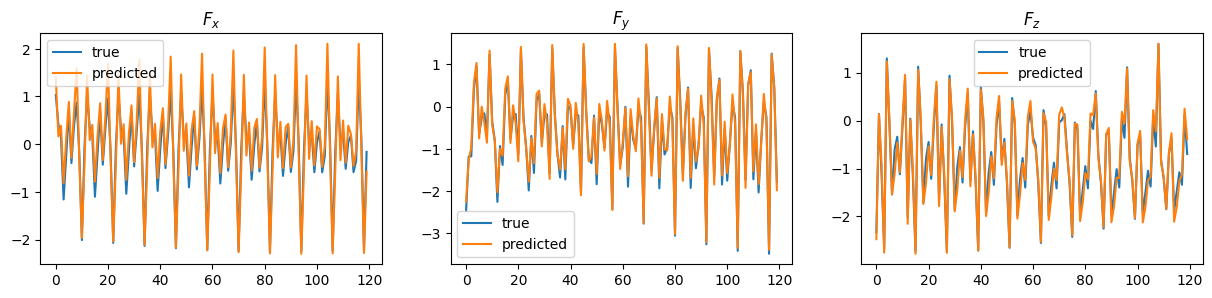

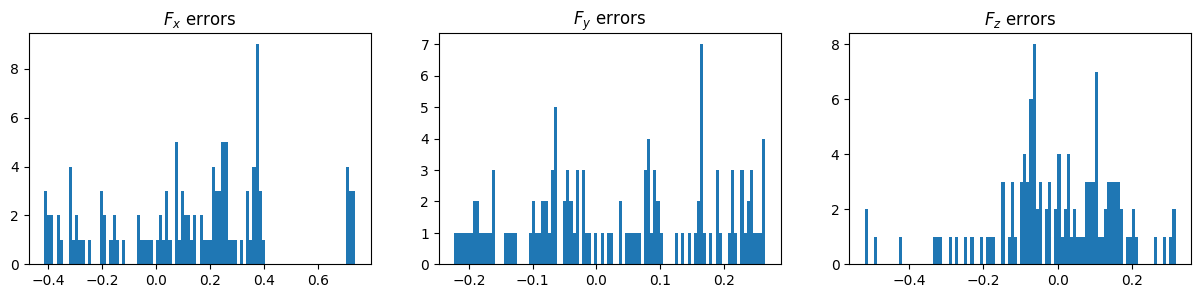

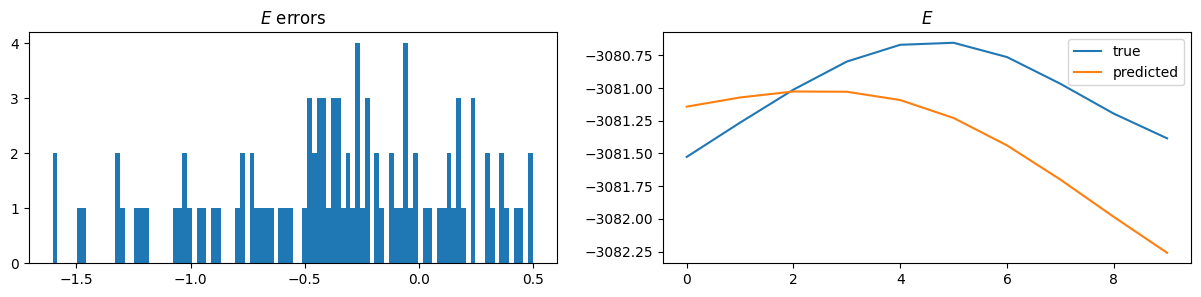

Atomic group [116, 117, 118, 119, 122, 123, 124, 125, 134, 135, 136, 137, 380, 381, 382, 383, 386, 387, 388, 389, 398, 399, 400, 401]
F_x
MAE 0.14678635009936522
RMSE 0.1847977603589074
F_y
MAE 0.09333918833247884
RMSE 0.1129145937046295
F_z
MAE 0.08722015050467936
RMSE 0.10496397936423287
E
MAE 0.4932021406875083
RMSE 0.6320239581193261


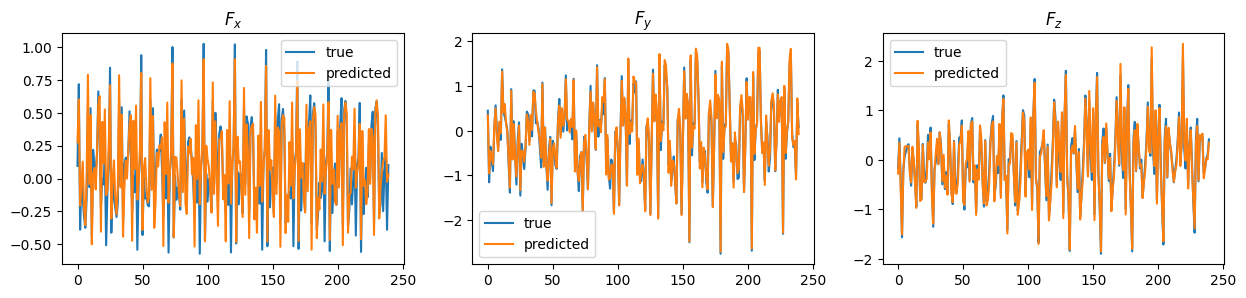

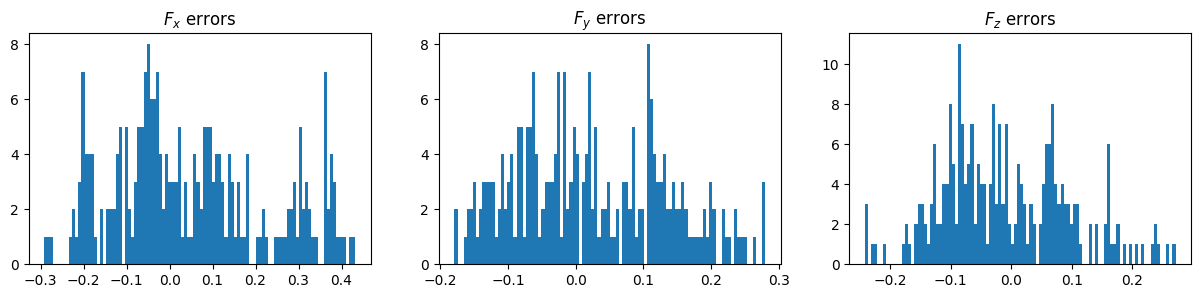

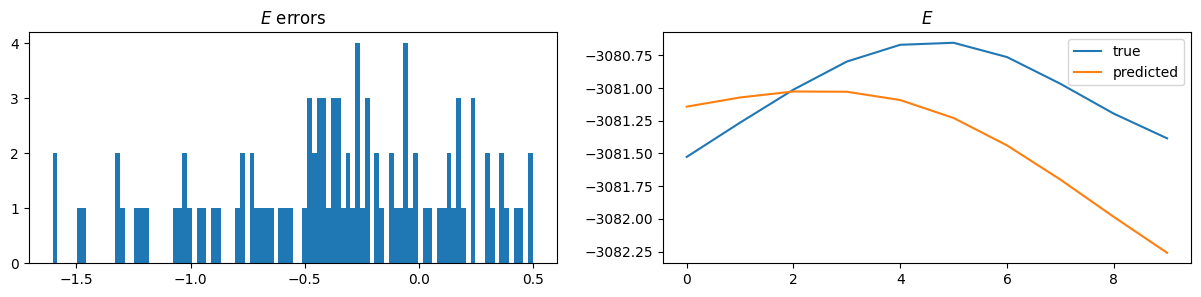

Atomic group [36, 37, 50, 51, 52, 53, 54, 55, 62, 63, 64, 65, 74, 75, 80, 81, 96, 97, 300, 301, 314, 315, 316, 317, 318, 319, 326, 327, 328, 329, 338, 339, 344, 345, 360, 361]
F_x
MAE 0.2344608165397678
RMSE 0.29061196203250195
F_y
MAE 0.2767365852025282
RMSE 0.33326232449876253
F_z
MAE 0.21045093185373262
RMSE 0.26255025059372494
E
MAE 0.4932021406875083
RMSE 0.6320239581193261


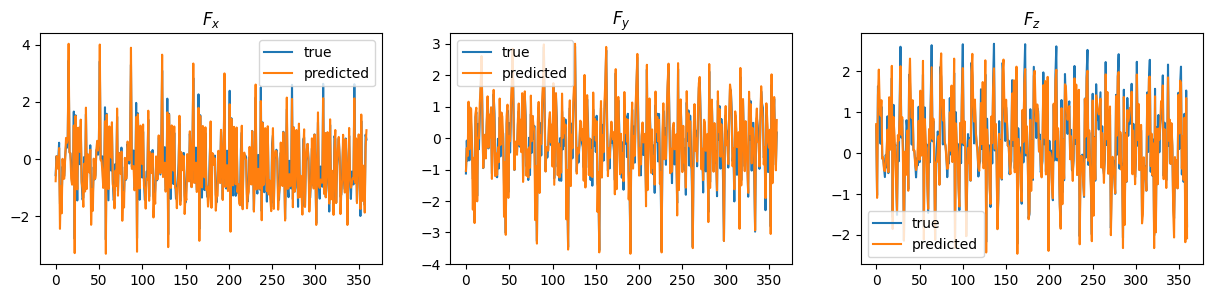

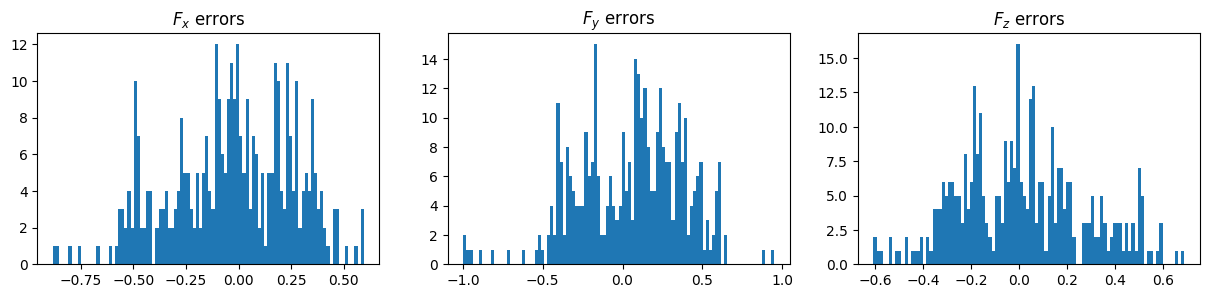

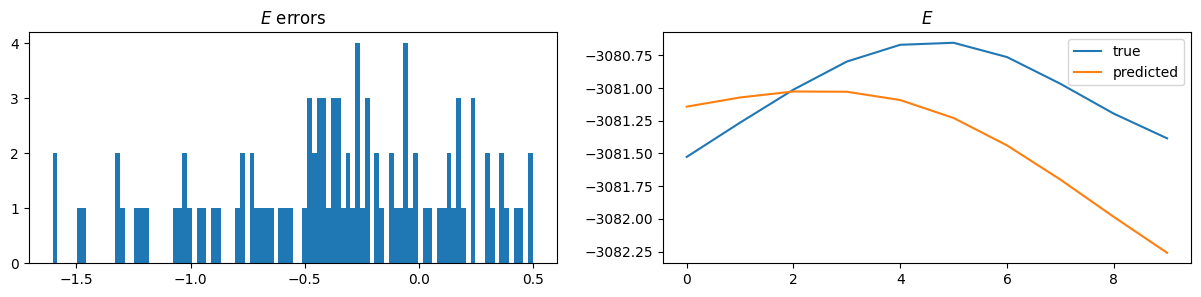

Atomic group [114, 115, 120, 121, 126, 127, 128, 129, 132, 133, 138, 139, 378, 379, 384, 385, 390, 391, 392, 393, 396, 397, 402, 403]
F_x
MAE 0.1280655770317383
RMSE 0.16059513855414242
F_y
MAE 0.07083055329044598
RMSE 0.08539802773445886
F_z
MAE 0.09549216661523438
RMSE 0.12299983059574154
E
MAE 0.4932021406875083
RMSE 0.6320239581193261


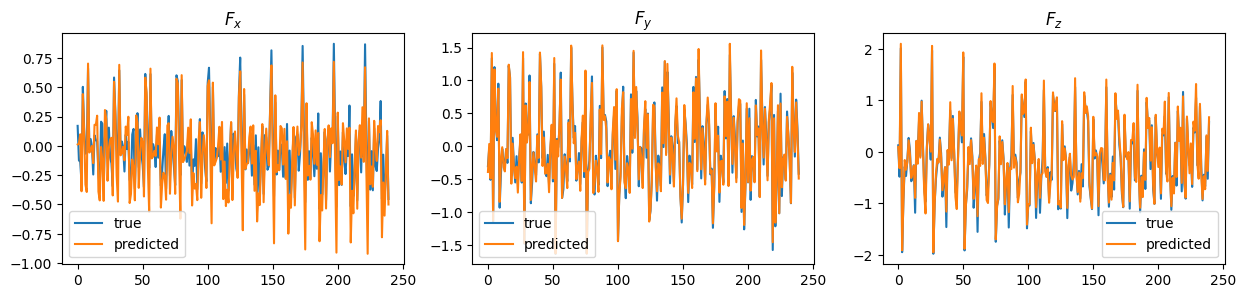

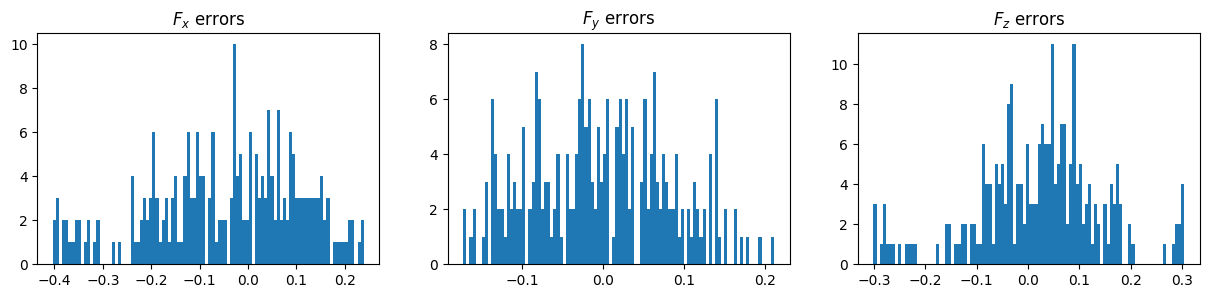

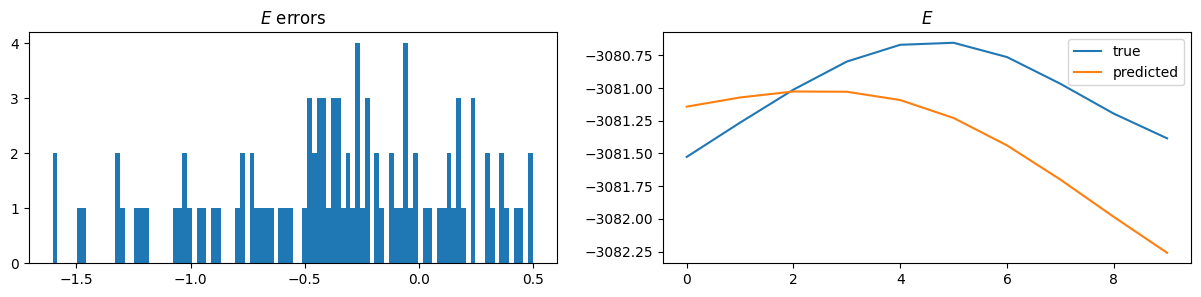

Atomic group [16, 17, 20, 21, 24, 25, 28, 29, 42, 43, 46, 47, 280, 281, 284, 285, 288, 289, 292, 293, 306, 307, 310, 311]
F_x
MAE 0.12039223353352864
RMSE 0.15013876133867504
F_y
MAE 0.23620239235416665
RMSE 0.29196547205527085
F_z
MAE 0.18891253587687176
RMSE 0.24171934414379945
E
MAE 0.4932021406875083
RMSE 0.6320239581193261


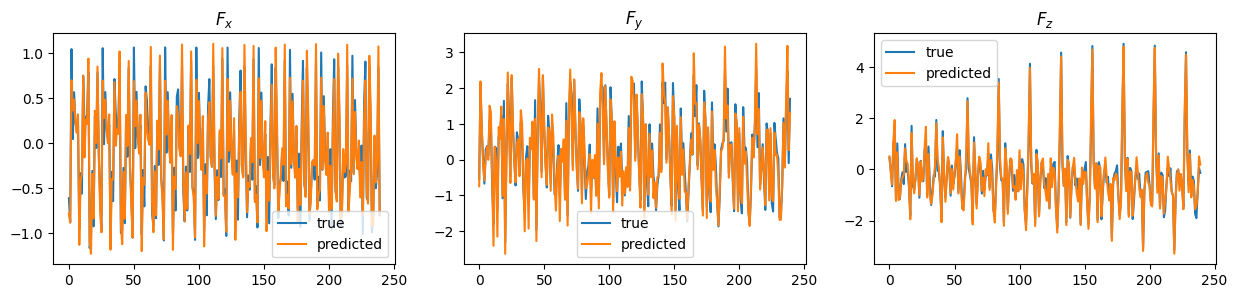

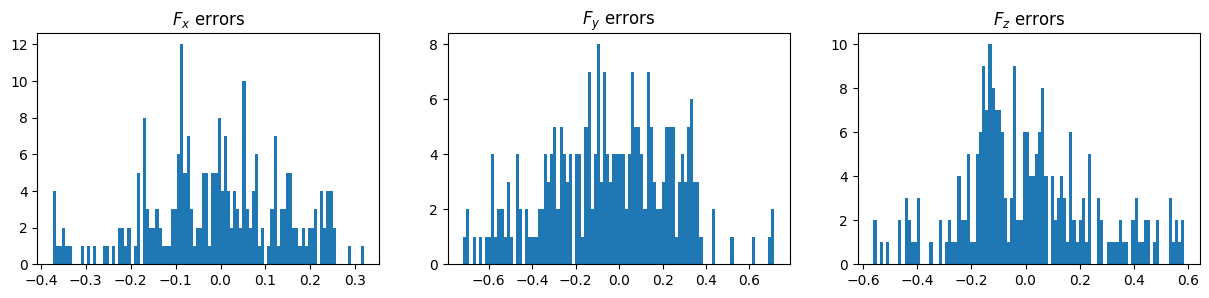

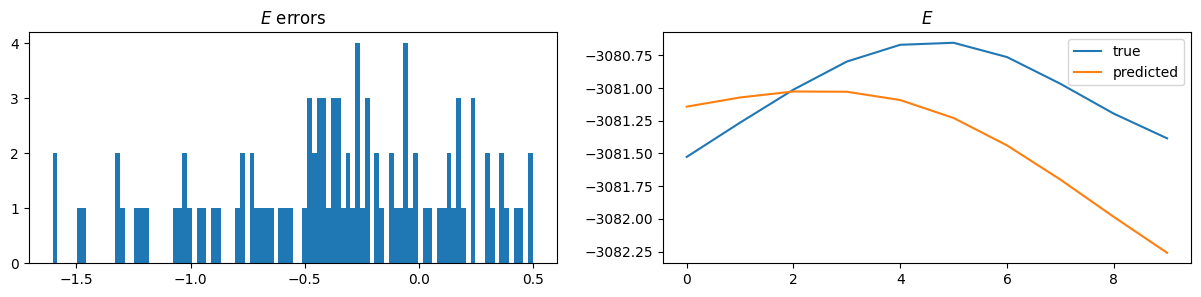

Atomic group [130, 131, 140, 141, 142, 143, 144, 145, 164, 165, 166, 167, 192, 193, 206, 207, 250, 251, 394, 395, 404, 405, 406, 407, 408, 409, 428, 429, 430, 431, 456, 457, 470, 471, 514, 515]
F_x
MAE 0.11259842363411457
RMSE 0.13544121070931595
F_y
MAE 0.09905669263313802
RMSE 0.12166616148679253
F_z
MAE 0.12051960342285158
RMSE 0.15224749091579162
E
MAE 0.4932021406875083
RMSE 0.6320239581193261


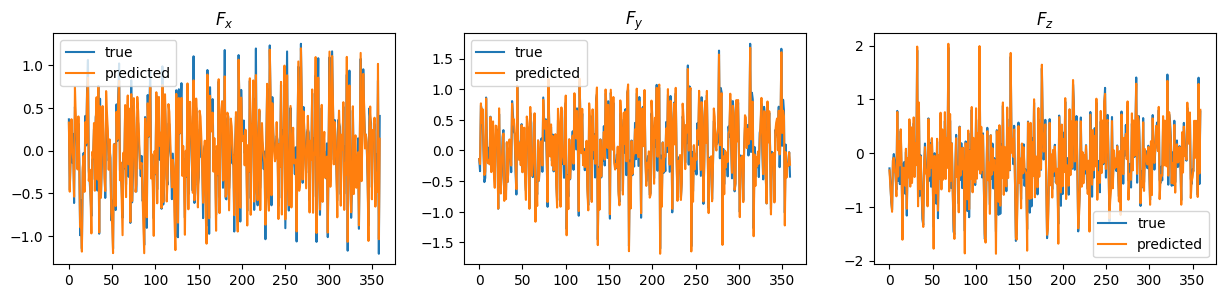

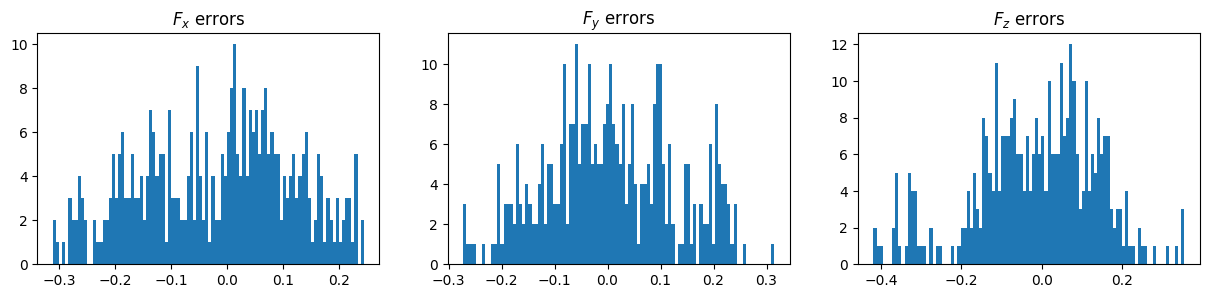

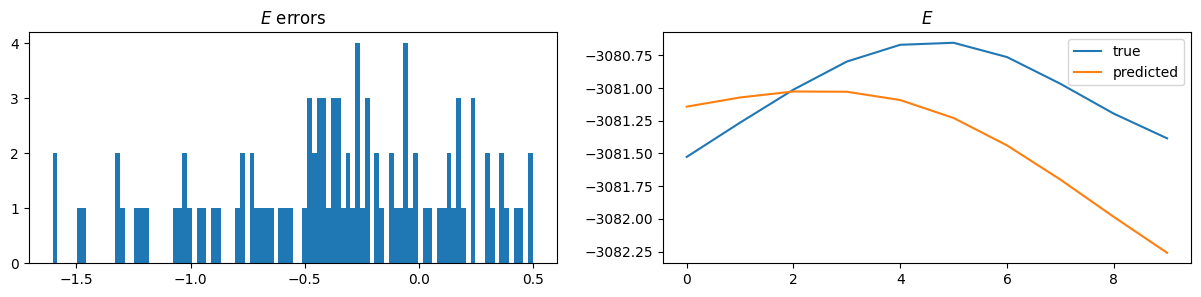

Atomic group [18, 19, 26, 27, 44, 45, 282, 283, 290, 291, 308, 309]
F_x
MAE 0.24523791090527344
RMSE 0.2775264171878297
F_y
MAE 0.1566677111315918
RMSE 0.19754487353525435
F_z
MAE 0.1780547229930013
RMSE 0.20402234132487326
E
MAE 0.4932021406875083
RMSE 0.6320239581193261


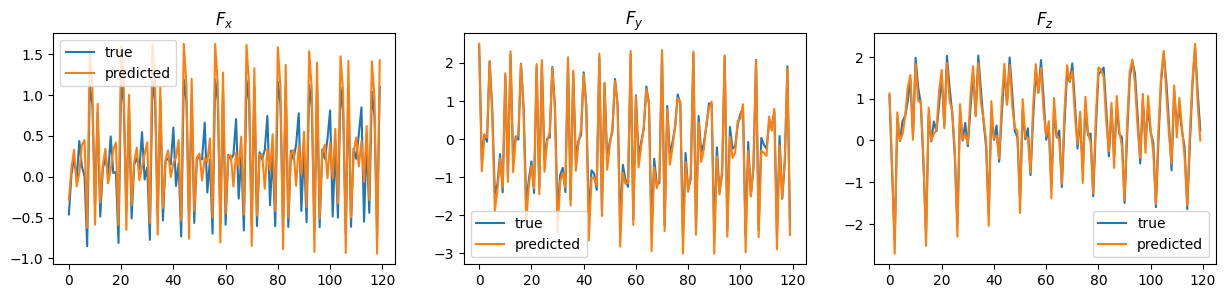

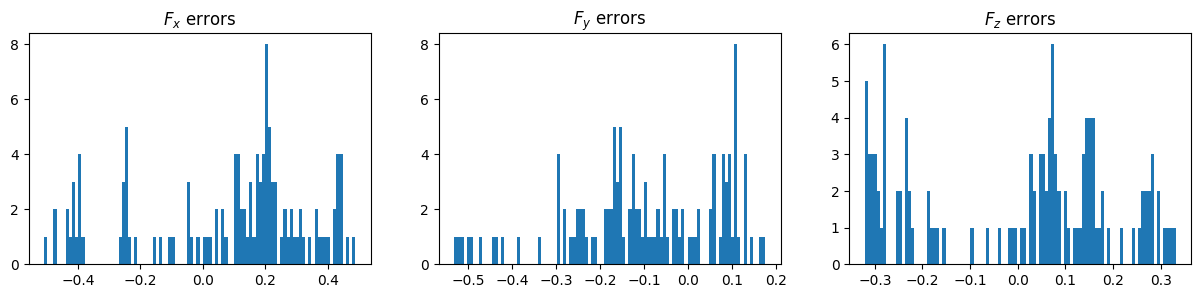

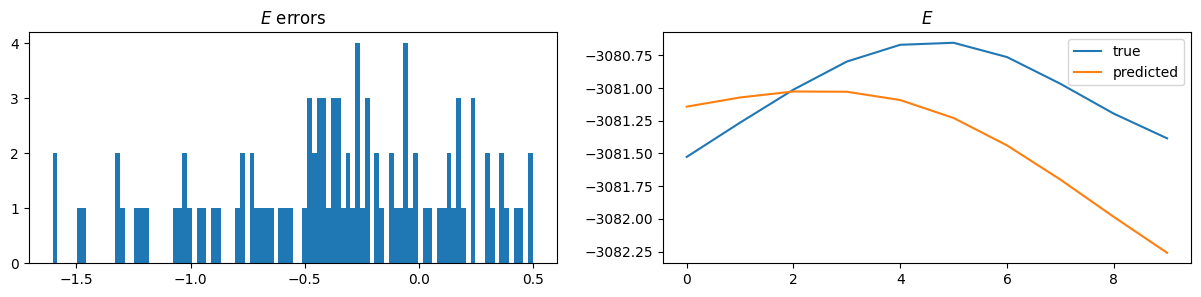

Atomic group [14, 15, 22, 23, 30, 31, 34, 35, 40, 41, 48, 49, 278, 279, 286, 287, 294, 295, 298, 299, 304, 305, 312, 313]
F_x
MAE 0.1328609691652832
RMSE 0.19530620100005713
F_y
MAE 0.2097821251812337
RMSE 0.2645473731599622
F_z
MAE 0.20610457199206542
RMSE 0.26830915478017525
E
MAE 0.4932021406875083
RMSE 0.6320239581193261


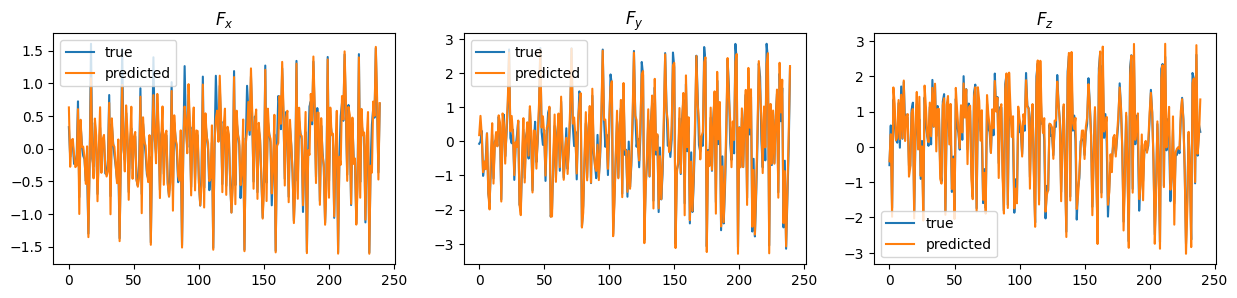

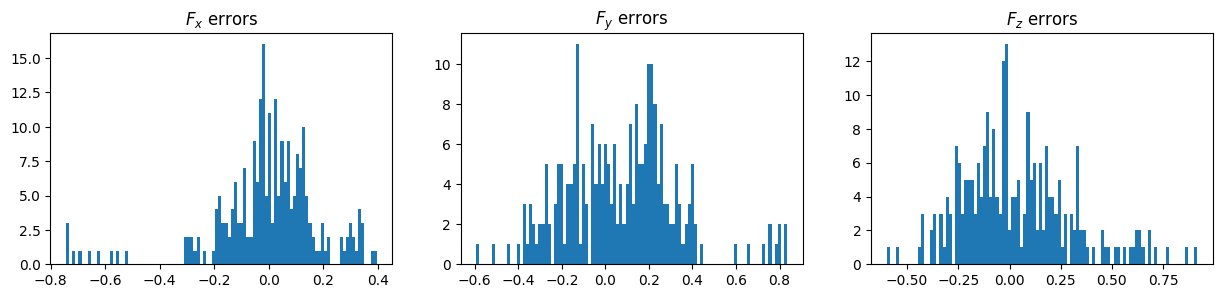

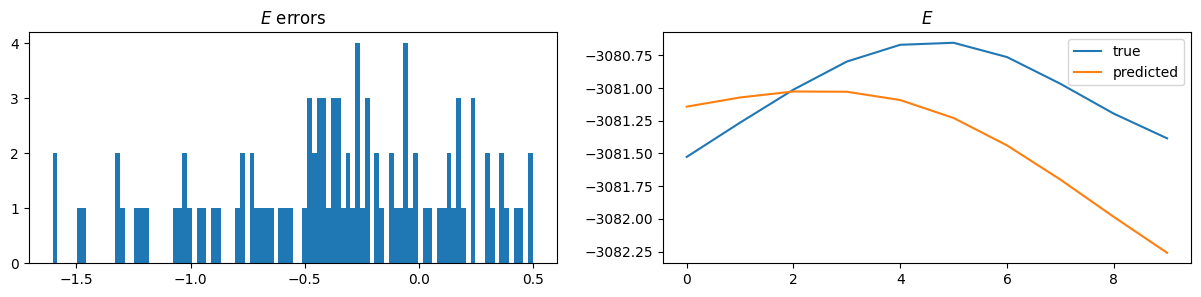

Atomic group [12, 13, 32, 33, 38, 39, 276, 277, 296, 297, 302, 303]
F_x
MAE 0.20260616137182616
RMSE 0.2502047763139248
F_y
MAE 0.2025870499601237
RMSE 0.23794335877382677
F_z
MAE 0.16502127276871745
RMSE 0.2079083734152529
E
MAE 0.4932021406875083
RMSE 0.6320239581193261


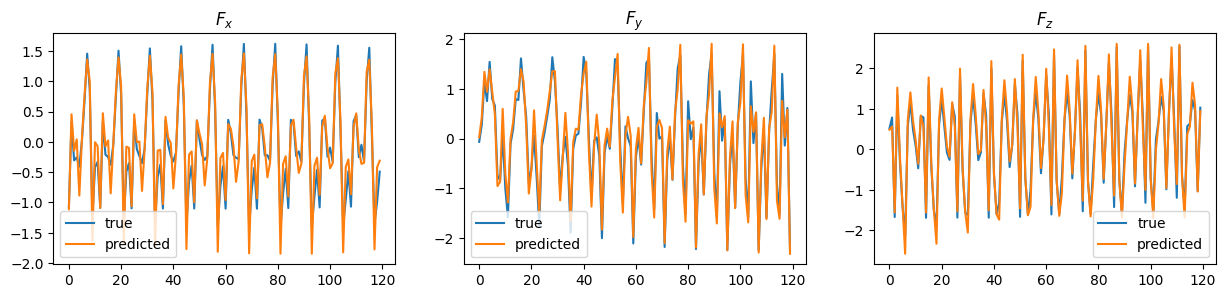

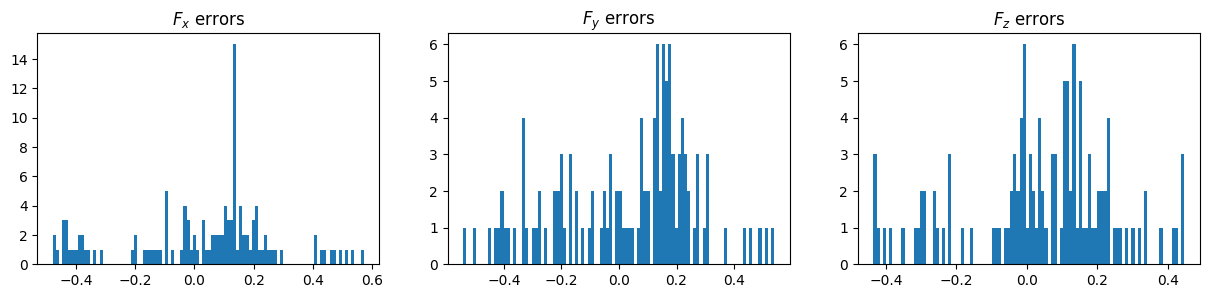

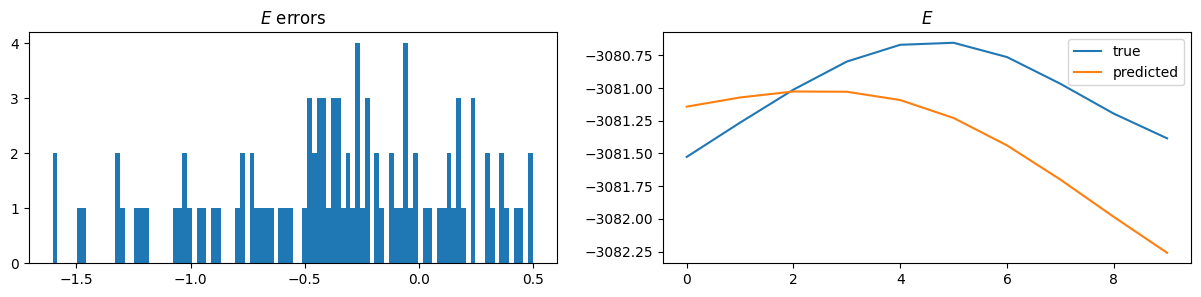

Atomic group [102, 103, 104, 105, 106, 107, 366, 367, 368, 369, 370, 371]
F_x
MAE 0.1567549923428548
RMSE 0.2304863481884983
F_y
MAE 0.14179662621919759
RMSE 0.1796780964363756
F_z
MAE 0.1261465513245036
RMSE 0.1664295446138634
E
MAE 0.4932021406875083
RMSE 0.6320239581193261


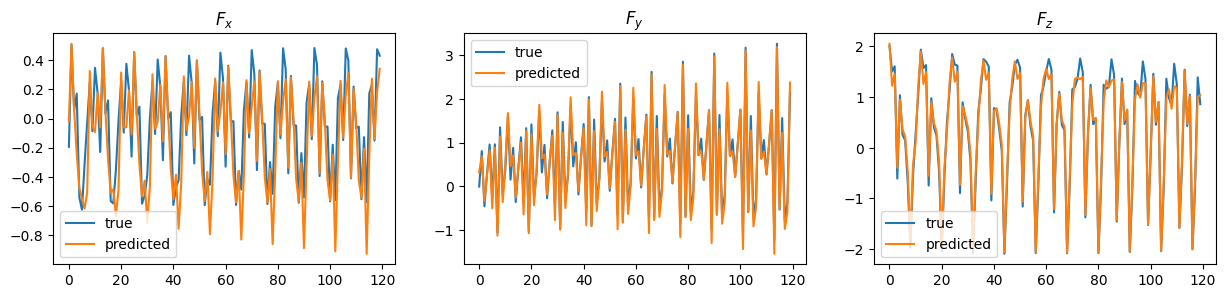

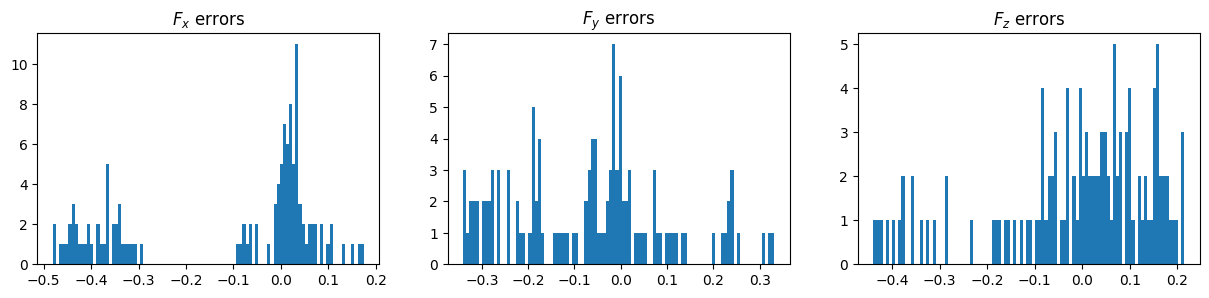

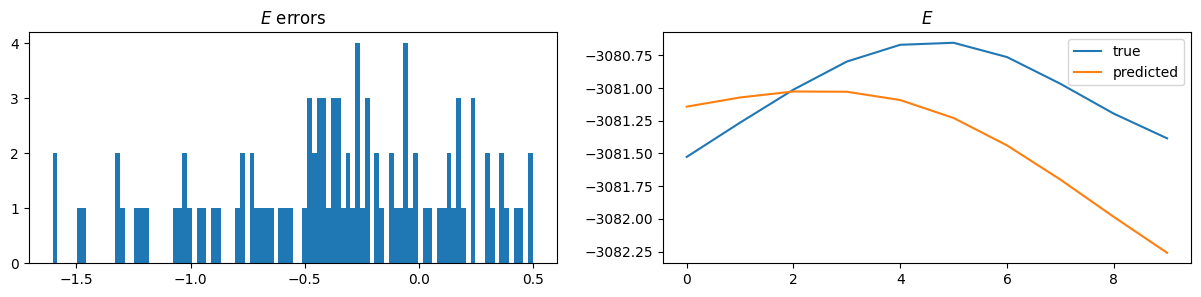

In [27]:
import numpy as np
import matplotlib.pyplot as plt

energy_true = np.array(energy_true)
energy_predicted = np.array(energy_predicted)
energy_errors = energy_predicted - energy_true

forces_true = np.array(forces_true)
forces_predicted = np.array(forces_predicted)
forces_errors = forces_predicted - forces_true

atomic_groups = predictor_loaded.fdm.atomic_groups



for ag in atomic_groups:

    print("Atomic group", ag)
    print("F_x")
    print("MAE", np.mean(np.abs(forces_errors[:, ag, 0].flatten())))
    print("RMSE", np.sqrt(np.mean(forces_errors[:, ag, 0].flatten()**2)))
    print("F_y")
    print("MAE", np.mean(np.abs(forces_errors[:, ag, 1].flatten())))
    print("RMSE", np.sqrt(np.mean(forces_errors[:, ag, 1].flatten()**2)))
    print("F_z")
    print("MAE", np.mean(np.abs(forces_errors[:, ag, 2].flatten())))
    print("RMSE", np.sqrt(np.mean(forces_errors[:, ag, 2].flatten()**2)))
    print("E")
    print("MAE", np.mean(np.abs(energy_errors.flatten())))
    print("RMSE", np.sqrt(np.mean(energy_errors.flatten()**2)))

    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))
    axs[0].set_title(r"$F_x$")
    axs[0].plot(np.array(forces_true)[:, ag, 0].flatten(), label="true")
    axs[0].plot(np.array(forces_predicted)[:, ag, 0].flatten(), label="predicted")
    axs[0].legend()

    axs[1].set_title(r"$F_y$")
    axs[1].plot(np.array(forces_true)[:, ag, 1].flatten(), label="true")
    axs[1].plot(np.array(forces_predicted)[:, ag, 1].flatten(), label="predicted")
    axs[1].legend()

    axs[2].set_title(r"$F_z$")
    axs[2].plot(np.array(forces_true)[:, ag, 2].flatten(), label="true")
    axs[2].plot(np.array(forces_predicted)[:, ag, 2].flatten(), label="predicted")
    axs[2].legend()

    plt.show()

    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))

    axs[0].set_title(r"$F_x$ errors")
    axs[0].hist(forces_errors[:, ag, 0].flatten(), bins=100)

    axs[1].set_title(r"$F_y$ errors")
    axs[1].hist(forces_errors[:, ag, 1].flatten(), bins=100)

    axs[2].set_title(r"$F_z$ errors")
    axs[2].hist(forces_errors[:, ag, 2].flatten(), bins=100)
    plt.show()

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 3))
    axs[0].set_title(r"$E$ errors")
    axs[0].hist(energy_errors.flatten(), bins=100)

    axs[1].set_title(r"$E$")
    axs[1].plot(energy_true, label="true")
    axs[1].plot(energy_predicted, label="predicted")
    axs[1].legend()
    plt.show()
